# Accessing and using BARRA2 and BARPA data for research

## BARRA2

Bureau of Meteorology Atmospheric high-resolution Regional Reanalysis for 
Australia - Version 2 (BARRA2) is a reanalysis from 1979 to the present day covering Australia, New Zealand and a portion of South-East Asia.

## BARPA

The Bureau of Meteorology Atmospheric Regional Projections for Australia (BARPA) delivers high-resolution dynamical downscaling of CMIP6 experiments over CORDEX-Australasia and Australian domains.

## NCI

Both these datasets are hosted at NCI on Gadi. Additional information on these datasets can be found in NCI's documentation pages for [BARPA](https://opus.nci.org.au/pages/viewpage.action?pageId=264241161https://opus.nci.org.au/pages/viewpage.action?pageId=264241161) and [BARRA2](https://opus.nci.org.au/pages/viewpage.action?pageId=264241166https://opus.nci.org.au/pages/viewpage.action?pageId=264241166).

<font color='red'>TODO add reference to OPUS pages for this workshop?</font>

## Accessing BARRA2 & BARPA

The outputs for BARRA2 and BARPA are store at NCI in the ob53 and py18 projects respectively.
Access to these projects can be requested in the usual way at the NCI account management pages - https://my.nci.org.au/mancini
The files are also available for direct download from NCI's Thredds server:
- [BARRA2](https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalogs/ob53/catalog.xml)
- [BARPA](https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalogs/py18/catalog.xml)

### List of variables

A list of the variables used by BARPA and BARRA2 can be found [here](https://github.com/joshuatorrance/barpa-barra2-amos2024/blob/main/BARRA2_BARPA_variable_list.csvhttps://github.com/joshuatorrance/barpa-barra2-amos2024/blob/main/BARRA2_BARPA_variable_list.csv).

***
This notebook covers some basic interactions with BARPA and BARRA2 data and some simple manipulations using *xarray*.

For more information on the multitude of tools available with *xarray* check out the xarray documentation:
https://docs.xarray.dev/en/stable/getting-started-guide/index.html
***

## Loading BARRA/BARPA data with Xarray & Dask

First we load the required python modules and start a dask client to speed up our computation.

In [1]:
# Imports for the notebook
import os
from glob import glob
from datetime import datetime
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs
import dask.distributed

In [2]:
# Let's explictly load dask so we can check progress
# Copy and paste the dashboard link/path from this cell's output
# to the Dask tab on the left.
client = dask.distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42673,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35163,Total threads: 1
Dashboard: /proxy/37525/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:42901,


There should now be a dask client running (click on "Launch dashboard in JupyterLab" to see the dashboard). The dask client will allow for better parallelisation of xarray operations such as opens multiple files or processing large datasets.

You can see the progress of dask operations in the dask dashboard.

***
Next we will build a path to the BARPA or BARRA2 data.

In [3]:
## Data location
# Let's define the path to the files we're interested in
# BARRA2
barra_r2_root_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1"

# BARPA
barpa_top_path = "/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM"
barpa_model = "ACCESS-CM2"
    # One BARPA model out of:
    # ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, EC-Earth3, ERA5, MPI-ESM1-2-HR, NorESM2-MM
barpa_scenario = "historical"
barpa_root_path = f"{barpa_top_path}/{barpa_model}/{barpa_scenario}/*/BARPA-R/v1-r1"

### Pick the root path that interests you, either BARPA or BARRA2, comment out the other one. ###
root_path = barra_r2_root_path
#root_path = barpa_root_path

## Time resolution
# e.g. BARRA - mon, day, 3hr, 1hr
#      BARPA - mon, day, 6hr, 1hr
time_resolution = "1hr"

## Variable
# Choose the variable to look at, e.g. "ts" for surface temperature
var = "ts"

## Date (YYYYMM)
# With glob we can use wild cards to find the files we want
# e.g. "2014??" for all of 2014 or "20140[123]" for the first three months
# Note that BARRA2 data has one file per month, BARPA data has one file per year
date = "2014??"

# Build a string to use with glob
glob_str = os.path.join(root_path, time_resolution, var, "*", f"*{date}.nc")

# Pass the string to glob will will return a matching list of file paths
file_list = sorted(glob(glob_str))

In [4]:
# Open the dataset

# If we have a single file we can use open_dataset
#ds = xr.open_dataset(file_list[0])

# If we have a list of files we use open_mfdataset
# Use parallel=True to take advantage of Dask's multiprocessing
ds = xr.open_mfdataset(file_list, parallel=True)

In [5]:
ds

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(744, 646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [6]:
ds[var].attrs

{'long_name': 'Surface Temperature',
 'standard_name': 'surface_temperature',
 'units': 'K',
 'cell_methods': 'time: point (interval: 1H)'}

## loaddata.py
loaddata.py is a module included with these notebooks to simplify access to BARPA and BARRA2 data.

More details and examples on this module can be found in the loaddata_demo notebook.

<font color='red'>TODO Copy dynamic notebook_dir to other notebooks</font>

In [7]:
# First define the location where you have clone the repository
notebook_dir = f"/scratch/om02/{os.environ['USER']}/barpa-barra2-amos2024"

# Now change the notebooks working directory to this location
os.chdir(notebook_dir)

# Now we can load the module
import loaddata

In [8]:
# Load some BARRA data
ds = loaddata.load_barra2_data("BARRA-R2", "1hr", "ts", tstart="2014010100", tend="2015010100")
ds

<xarray.Dataset>
Dimensions:  (time: 8761, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T01:00:00 ... 2015-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(744, 646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [9]:
# Load some BARPA data
ds = loaddata.load_barpa_data("BARPA-R", "ACCESS-CM2", "historical", "1hr", "ts", tstart="2014010100", tend="2015010100")
ds

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 436, lon: 777)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(8760, 436, 777), meta=np.ndarray>
Attributes: (12/57)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    title:                     Bureau of Meteorology Atmospheric Regional Pro...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science, Atmosphere; Continent, Australi...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; historical; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    date_modified:             2023-11-16T17:10:01Z
    date_metadata_modified:    2023-11-16T17:10:01Z

### Load data contains some other helpful functions
Here's a couple of them

In [10]:
# Examine a particular variable
_ = loaddata.whatis('1hr', 'pr')

Short name: pr
long_name: Precipitation
standard_name: precipitation_flux
units: kg m-2 s-1
cell_methods: time: mean (interval: 1 hour)


In [11]:
# List the available variables
_ = loaddata.list_barra2_variables('BARRA-R2', '1hr')

rsut, rluscs, ta1500m, va400, pr, ta200m, ta700, clwvi, hus500, tas, uasmean, mrsos, ua400, zg925, ta250m, rlus, prc, va150m, ua300, zg300, zg400, zg850, ua850, va250m, va200m, ta600, rsdscs, wa300, ua50m, hus200, ps, ta50m, omega500, prsn, va600, tasmean, cll, hus400, vasmean, wa700, wsgsmax, uasmax, vasmax, ua250m, CAPE, va850, ua700, ua1000, hus1000, ua200m, va700, hus950, ua150m, ua1500m, prw, va300, wa1000, ua600, ua100m, ua925, zg200, wa600, va100m, va200, rsutcs, rsds, evspsblpot, hus600, zg1000, ua500, sfcWind, mrfsos, hfls, ta850, ta100m, ua200, rsdt, clh, va925, zg600, hus300, zg500, hurs, psl, ts, vas, huss, rldscs, ta925, ta150m, wa500, va1500m, uas, hus700, ta500, zg700, clivi, wa200, va50m, ta200, rlutcs, tasmin, ta300, clm, CIN, ta400, rlds, wa400, zmla, va1000, rsdsdir, rsuscs, hfss, rlut, wa850, ta1000, va500, clt, ta950, wa925, tasmax, hus850, rsus, hus925


## Instantaneous vs. Accumulated variables
The variables used in BARPA and BARRA2 can be separated into two group, *instantaneous* and *accumulated*.

*Instantaneous* variables give a snapshot of the underlying model stat at the given time.

*Accumulated* variables give an aggregate view of a given time window (e.g. hourly mean, daily max). Accumulated variables will have an additional coordinate, 'time_bnds'.

It's important to note that time values are different between instantaneous and accumulated variables.
For instantaneous variables the time value match the start of the window when snapshot was taken, i.e. 00:00, 01:00.
Accumulated variables use time values in the centre of their window, i.e. 00:30, 01:30.

It's important to keep these different time values in mind if one if combining variables in some way, e.g. performing arithmetic or plotting.

In [20]:
var = 'tas'
time_resolution = '1hr'

# What is this variable?
loaddata.whatis(time_resolution, var)

# Take a look at the first time step
ds_inst = loaddata.load_barra2_data("BARRA-R2", time_resolution, var, tstart="2014010100", tend="2015010100")
ds_inst['time'][0].data

Short name: tas
long_name: Near-Surface Air Temperature
standard_name: air_temperature
units: K
cell_methods: time: point (interval: 1H)


array('2014-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [13]:
var = 'tasmax'
time_resolution = '1hr'

# What is this variable?
loaddata.whatis(time_resolution, var)

# Take a look a the first time step
ds_accum = loaddata.load_barra2_data("BARRA-R2", time_resolution, var, tstart="2014010100", tend="2015010100")
ds_accum['time'][0].data

Short name: tasmax
long_name: Hourly Maximum Near-Surface Air Temperature
standard_name: air_temperature
units: K
cell_methods: time: maximum (interval: 1 hour)


array('2014-01-01T00:30:00.000000000', dtype='datetime64[ns]')

In [21]:
# Accumulated variables have time_bnds
ds_accum['time_bnds'][0:3].compute()

<xarray.DataArray 'time_bnds' (time: 3, bnds: 2)>
array([['2014-01-01T00:00:00.000000000', '2014-01-01T01:00:00.000000000'],
       ['2014-01-01T01:00:00.000000000', '2014-01-01T02:00:00.000000000'],
       ['2014-01-01T02:00:00.000000000', '2014-01-01T03:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T00:30:00 ... 2014-01-01T02:30:00
    height   float64 1.5
  * bnds     (bnds) float64 0.0 1.0

## Indexing and Plotting Data
Xarray has sophisticated indexing tools available.
There are many ways to index data with Xarray, below are a couple of examples.

See Xarray's [documentation](https://docs.xarray.dev/en/latest/user-guide/indexing.html) for more details.

Xarray data sets can be easily plotting with matplotlib.

In [27]:
var = 'ts'
ds = loaddata.load_barra2_data("BARRA-R2", "1hr", var, tstart="2014010100", tend="2015010100")
ds

<xarray.Dataset>
Dimensions:  (time: 8761, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T01:00:00 ... 2015-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(744, 646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

### First timestep

In [16]:
# Select the first timestep using the index
ds_first_timestep = ds.isel(time=0)
ds_first_timestep

<xarray.Dataset>
Dimensions:  (lat: 646, lon: 1082)
Coordinates:
    time     datetime64[ns] 2014-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (lat, lon) float64 dask.array<chunksize=(646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [24]:
# Alternatively select the first timestep by giving a string
# Look what happens if we don't specify said string precisely
ds.sel(time='2014-01-01')

<xarray.Dataset>
Dimensions:  (time: 24, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-01-01T23:00:00
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(24, 646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [25]:
# Alternatively select the first timestep by giving a string
# Look what happens if we don't specify said string precisely
ds_first_timestep = ds.sel(time='2014-01-01T00:00')
ds_first_timestep

<xarray.Dataset>
Dimensions:  (lat: 646, lon: 1082)
Coordinates:
    time     datetime64[ns] 2014-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (lat, lon) float64 dask.array<chunksize=(646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

### Basic Plotting
xarray uses matplotlib to allow for quick and convenient plotting.

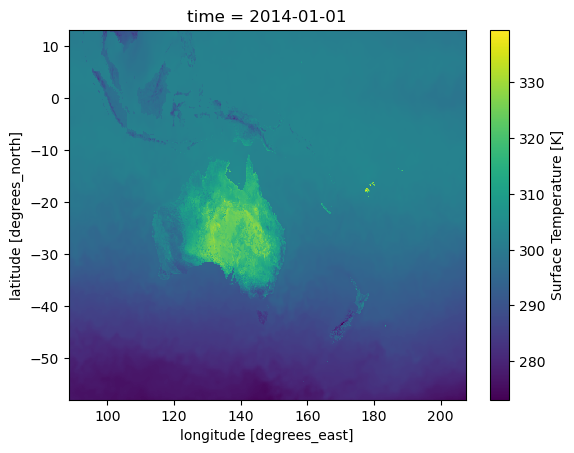

In [28]:
# Plot the first field

# Can only plot data arrays (not datasets)
da = ds_first_timestep[var]
da.plot()

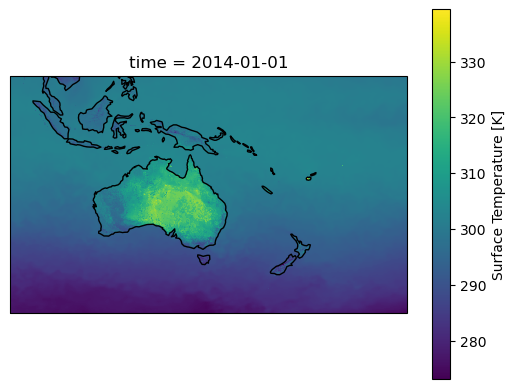

In [29]:
# Plot the first field - with coastlines!

# Can only plot data arrays (not datasets)
da = ds_first_timestep[var]

# Build a cartopy projection so we can draw on the coastlines
centre_lon = da['lon'].mean().values
projection = cartopy.crs.PlateCarree(central_longitude=centre_lon)

# Now plot the field with the transform.
plot = da.plot(
    transform=cartopy.crs.PlateCarree(),
    subplot_kws={"projection": projection})

# Draw the coastlines using cartopy
plot.axes.coastlines()

### More indexing - Zoom in on Melbourne

In [30]:
# Select the Melbourne region using slice
melb_lat, melb_lon = -37.840935, 144.946457
width = 1.5

ds_melb = ds.sel(lat=slice(melb_lat - width/2, melb_lat + width/2),
                 lon=slice(melb_lon - width/2, melb_lon + width/2))

In [31]:
# Let's convert the temperature to centigrade
ds_melb[var] = ds_melb[var] - 273.25

# The above arithmetic will not preserve the DataArray's attributes
# So let's copy them here and update the units.
ds_melb[var].attrs = ds[var].attrs
ds_melb[var].attrs['units'] = 'C'

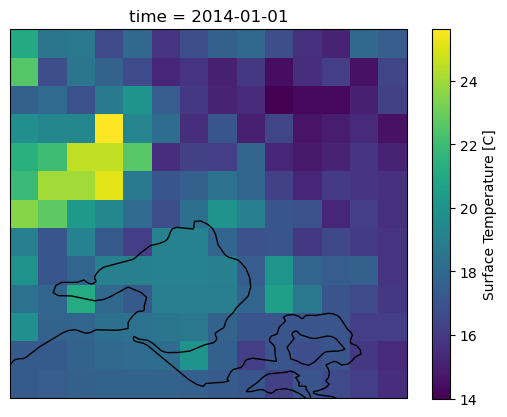

In [32]:
# Let's plot the resulting data array as we did before
# We can reuse the project we defined earlier
da = ds_melb.isel(time=0)[var]

plot = da.plot(
    transform=cartopy.crs.PlateCarree(),
    subplot_kws={"projection": projection})

plot.axes.coastlines()

### Data Manipulation - Mean temperature in Melbourne during 2014

Text(0.5, 1.0, 'Mean Surface Temperature in Melbourne region (C)')

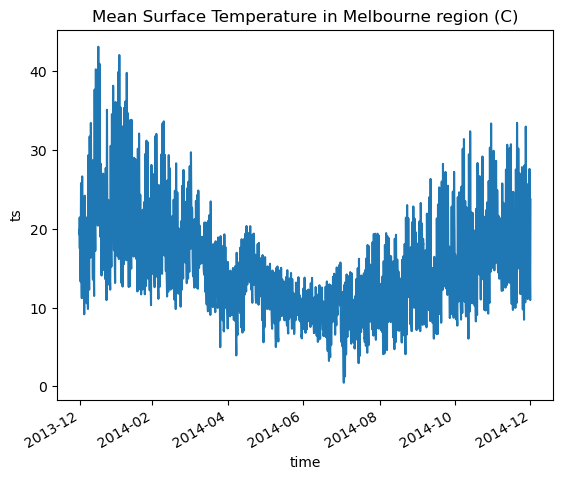

In [33]:
# Take our Melbourne dataset and caculate the mean of each spatial field then plot the result
ds_melb[var].mean(dim=['lat', 'lon']).plot()

# xarray uses matplotlib to handle the plotting
# Add a custom title to the plot using the standard matplotlib command
plt.title(f"Mean {da.attrs['long_name']} in Melbourne region ({da.attrs['units']})")

### Exercises
1. Plot the average temperature in Melbourne by time-of-day
2. Plot the min and max daily temperatures in Melbourne

In [34]:
# First get time in the the local Melb timezone
# Use pandas to add the UTC timezone to 'time', convert it to Melbourne's timezone (AEDT), then remove the timezone again
time_melb = pd.to_datetime(ds_melb['time']).tz_localize('UTC').tz_convert('Australia/Melbourne').tz_localize(None)

# Replace time with time_melb
ds_melb_aedt = ds_melb.assign_coords(time_melb=("time", time_melb)).drop('time').swap_dims({'time': 'time_melb'})

# Add the attributes for time_melb so our plots below are nicer
ds_melb_aedt['time_melb'].attrs = {'standard_name': 'time_melb', 'axis': 'T', 'long_name': 'Time in AEDT'}

ds_melb_aedt

<xarray.Dataset>
Dimensions:    (time_melb: 8761, lat: 13, lon: 14)
Coordinates:
  * lat        (lat) float64 -38.5 -38.39 -38.28 -38.17 ... -37.4 -37.29 -37.18
  * lon        (lon) float64 144.2 144.4 144.5 144.6 ... 145.3 145.5 145.6 145.7
  * time_melb  (time_melb) datetime64[ns] 2014-01-01T11:00:00 ... 2015-01-01T...
Data variables:
    ts         (time_melb, lat, lon) float64 dask.array<chunksize=(744, 13, 14), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

#### Average temperature by time of day

Text(0, 0.5, 'Mean Surface Temperature (C)')

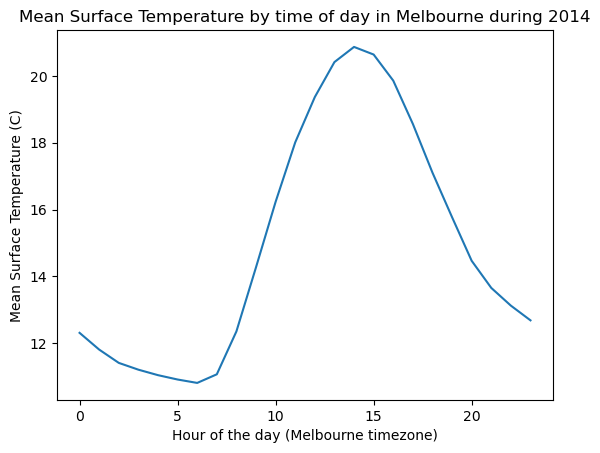

In [35]:
# Now plot the mean spatial field value, averaged for each hour of the day
ds_melb_aedt[var].mean(dim=['lat', 'lon']).groupby("time_melb.hour").mean().plot()

plt.title(f'Mean {ds_melb_aedt[var].attrs["long_name"]} by time of day in Melbourne during 2014')

plt.xlabel(f'Hour of the day (Melbourne timezone)')
plt.ylabel(f'Mean {ds_melb_aedt[var].attrs["long_name"]} ({ds_melb_aedt[var].attrs["units"]})')

#### Min and Max Temperature

Text(0, 0.5, 'Surface Temperature (C)')

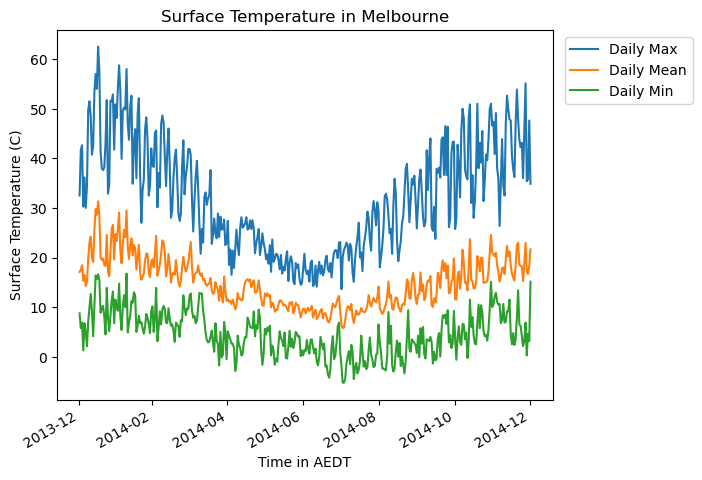

In [36]:
# Daily min and max is usually from 9am to 9am
# Resample our hourly data into daily data, and offset to 9am
ds_melb_aedt.resample({'time_melb': '1D'}, offset='+9H').max().max(dim=['lat', 'lon'])[var].plot(label='Daily Max')
ds_melb_aedt.resample({'time_melb': '1D'}, offset='+9H').mean().mean(dim=['lat', 'lon'])[var].plot(label='Daily Mean')
ds_melb_aedt.resample({'time_melb': '1D'}, offset='+9H').min().min(dim=['lat', 'lon'])[var].plot(label='Daily Min')

# Let's add a legend and title, etc.
plt.legend(bbox_to_anchor=(1.01, 1.0))

plt.title(f'{ds_melb_aedt[var].attrs["long_name"]} in Melbourne')

plt.xlabel(f'{ds_melb_aedt["time_melb"].attrs["long_name"]}')
plt.ylabel(f'{ds_melb_aedt[var].attrs["long_name"]} ({ds_melb_aedt[var].attrs["units"]})')